## 1. Importing the necessary libraries and defining constants.

In [190]:
import polars as pl
import polars.selectors as sc

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

import pathlib as path
import shutil 

 # Define the ratio of the plot.
fig_aspect_ratio : float = 4/3 # width/height ratio
height : float = 6
width: float = height * fig_aspect_ratio


# Assign an ordinal number to each month to promote the proper order of the months in directories (January, February etc.)
month_order : dict[str, int] = {
                "January":1,
                "February":2,
                "March":3,
                "April":4,
                "May":5,
                "June":6,
                "July":7,
                "August":8,
                "September":9,
                "October":10,
                "November":11,
                "December":12
                }
int2month : dict[int, str] = {month_order[key] : key for key in month_order.keys()}

            
main_path: path.Path = path.Path().cwd()/"Financial summaries"

if main_path.exists():
    shutil.rmtree(main_path)

# 2. Reading the data from Excel sheets.

In [191]:
# Read the expenses data from the Excel file.
expenses_df = pl.read_excel(
    "Expenses.xlsx",
    sheet_name="Expenses",
    has_header=True
)

# Read the income data from the Excel file.
income_df = pl.read_excel(
    "Incomes.xlsx",
    sheet_name="Incomes",
    has_header=True
)

# Display the expenses DataFrame.
expenses_df

Expense date,Where bought?,What bought?,Expense cost,Volume unit,Volume amount,Expense category,Product category
date,str,str,f64,str,f64,str,str
2024-02-01,"""Biedronka""","""Ser żółty światowid""",13.98,"""gram""",600.0,"""Groceries""","""Ser"""
2024-02-01,"""Biedronka""","""Woda gazowana muszynianka""",2.99,"""ml""",1500.0,"""Drinks""","""Woda"""
2024-02-01,"""Biedronka""","""Ryż brązowy plony natury""",5.98,"""gram""",800.0,"""Groceries""","""Ryż"""
2024-02-01,"""Biedronka""","""Serek wiejski""",5.97,"""gram""",600.0,"""Groceries""","""Serek wiejski"""
2024-02-01,"""Biedronka""","""Olej słonecznikowy""",7.99,"""ml""",1000.0,"""Groceries""","""Olej spożywczy"""
…,…,…,…,…,…,…,…
2025-02-20,"""Pizzeria Diabolo""","""Sos czosnkowy""",2.5,"""sztuka""",1.0,"""DiningOut""","""Sos"""
2025-02-21,"""Rossmann""","""Krem do rąk Neutrogena""",11.99,"""ml""",75.0,"""Hygiene""","""Krem do rąk"""
2025-02-21,"""Hubert Górski""","""Tankowanie samochodu""",26.0,"""sztuka""",1.0,"""Travel""","""Gas/benzyna"""


# 3. Grouping the costs by month and year.

In [192]:
# Group the expenses by year, quarter, and month, then sum the costs.
grouped_expenses = (
    expenses_df.group_by(
        pl.col("Expense date").dt.year().alias("Year"),
        pl.col("Expense date").dt.quarter().alias("Quarter"),
        pl.col("Expense date").dt.strftime("%b").alias("Month"),
        maintain_order=True
    ).agg(
        pl.col("Expense cost").sum().alias("Total expenses")
    )
)

# Group the incomes by year, quarter, and month, then sum the amounts.
grouped_income = (
    income_df.group_by(
        pl.col("Income date").dt.year().alias("Year"),
        pl.col("Income date").dt.quarter().alias("Quarter"),
        pl.col("Income date").dt.strftime("%b").alias("Month"),
        maintain_order=True
    ).agg(
        pl.col("Income amount").sum().alias("Total incomes")
    )
)

grouped_expenses

Year,Quarter,Month,Total expenses
i32,i8,str,f64
2024,1,"""Feb""",2390.98
2024,1,"""Mar""",4077.91
2024,2,"""Apr""",1919.3
2024,2,"""May""",3077.2
2024,2,"""Jun""",1654.12
…,…,…,…
2024,4,"""Oct""",1936.07
2024,4,"""Nov""",1861.825
2024,4,"""Dec""",1044.22


# 4. Preprocessing the balance sheets for plotting.

In [193]:
# Join the grouped_income with grouped_expense.
balances = (
    grouped_income.join(
        grouped_expenses,
        on=(pl.col("Year"), pl.col("Month")),
        how="full"
    ).select(
        ~sc.ends_with("right")
    ).fill_null(0)
)

# Add a column "Monthly balance".
balances = balances.with_columns(
    (pl.col("Total incomes") - pl.col("Total expenses")).alias("Monthly balance")
)

# Convert the balance sheet to long form.
balances_long = balances.unpivot(
    index=("Year", "Quarter", "Month"),
    variable_name="Financial category",
    value_name="Amount"
)

fin_cat = pl.col("Financial category")

hue_variable = (
    pl.when(fin_cat.is_in(["Total incomes", "Total expenses"]))
    .then(fin_cat)
    .otherwise(
        pl.when(pl.col("Amount") >= 0)
        .then(pl.lit("Positive balance"))
        .otherwise(pl.lit("Negative balance"))
    ).alias("Financial category")
)

balances_long = balances_long.with_columns(hue_variable)

balances_long

Year,Quarter,Month,Financial category,Amount
i32,i8,str,str,f64
2024,1,"""Feb""","""Total incomes""",1468.0
2024,1,"""Mar""","""Total incomes""",1070.0
2024,2,"""Apr""","""Total incomes""",1606.5
2024,2,"""May""","""Total incomes""",1630.0
2024,2,"""Jun""","""Total incomes""",1928.0
…,…,…,…,…
2024,4,"""Oct""","""Positive balance""",448.86
2024,4,"""Nov""","""Positive balance""",515.225
2024,4,"""Dec""","""Positive balance""",2380.78


# 5. Visualizing the annual general balance sheets.

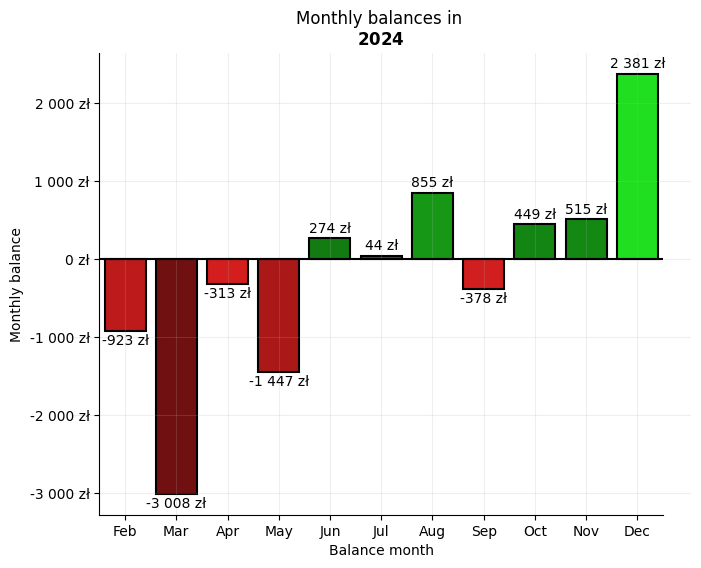

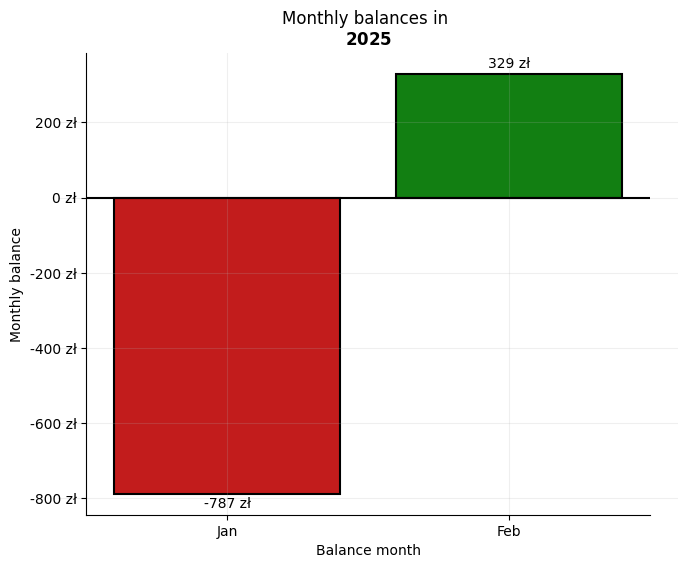

In [194]:
# Filter the balances_long DataFrame to get only the monthly balances.
monthly_balances = balances_long.filter(
    pl.col("Financial category").str.ends_with("balance")
)

# Create a Normalizer for our data for the color map to work properly.
normalize = colors.Normalize(
    monthly_balances["Amount"].min(),
    monthly_balances["Amount"].max()
)

# Find the "turning" normalized value (that is, if normalize(x) < x0 then x is negative, otherwise - positive).
x0 = normalize(0)

# Define the color entries for the LinearSegmentedColorMap.
red = [(0, 0, 0.5), (x0, 1, 0), (1, 0, 0)]
green = [(0, 0, 0), (x0, 0, 0.5), (1, 1, 1)]
blue = [(0, 0, 0), (1, 0, 0)]
alpha = [(0, 1, 1), (x0, 0, 0), (1, 1, 1)]

# Create a custom color map.
financial_colormap = colors.LinearSegmentedColormap(
    "FinancialPalette",
    {"red": red, "green": green, "blue": blue, "alpha": alpha}
)


def generate_month_balance_sheet(year: int) -> None:
    """The function generates the month balance sheet plot for a given year. All of the plots are saved in a given path.
    
    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None
    """
    # Filter the balance sheet by year.
    df_filtered = monthly_balances.filter(pl.col("Year") == year)

    # Convert the values to color.
    kolory = [financial_colormap(normalize(v)) for v in df_filtered["Amount"]]

    # Create a figure.
    global width, height
    figure = plt.figure(figsize=(width, height))
    axes = sns.barplot(
        data=df_filtered, 
        x="Month", 
        y="Amount", 
        palette=kolory, 
        hue="Month", 
        legend=False,
        edgecolor="black", 
        linewidth=1.5
    )

    # Customizing the plot.
    axes.spines[["top", "right"]].set_visible(False)
    axes.grid(True, alpha=0.2)

    # Setting the title of the plot and axis labels.
    axes.set_title(f"Monthly balances in \n$\\bf{{{year}}}$")
    axes.set_ylabel("Monthly balance")
    axes.set_xlabel("Balance month")

    # Adjust the bounds of the bottom spine.
    xlim = axes.get_xlim()
    axes.spines["bottom"].set_bounds(xlim[0], xlim[1])

    # Set the position of the left spine.
    axes.spines["left"].set_position(("data", xlim[0]))

    # Add a new Ox axis at position y=0.
    axes.hlines(0, xlim[0], xlim[1], colors="black")

    # Set the major formatter for the y-axis.
    axes.yaxis.set_major_formatter(lambda x, v: f"{x:,.0f} zł".replace(",", " "))

    # Add labels to the bars.
    for container in axes.containers:
        axes.bar_label(container, fmt=lambda v: f"{v:,.0f} zł".replace(",", " "), padding=2)

    # Define the saving path.
    saving_path = main_path / f"{year}"

    if not saving_path.exists():
        saving_path.mkdir(parents=True)

    # Save the figure.
    figure.savefig(fname=saving_path / "General monthly balance.png")

# Generate the month balance sheets for each year available in the dataset.
for year in monthly_balances["Year"].unique():
    generate_month_balance_sheet(year)

# 6. Visualizing the income and expenses for each month.

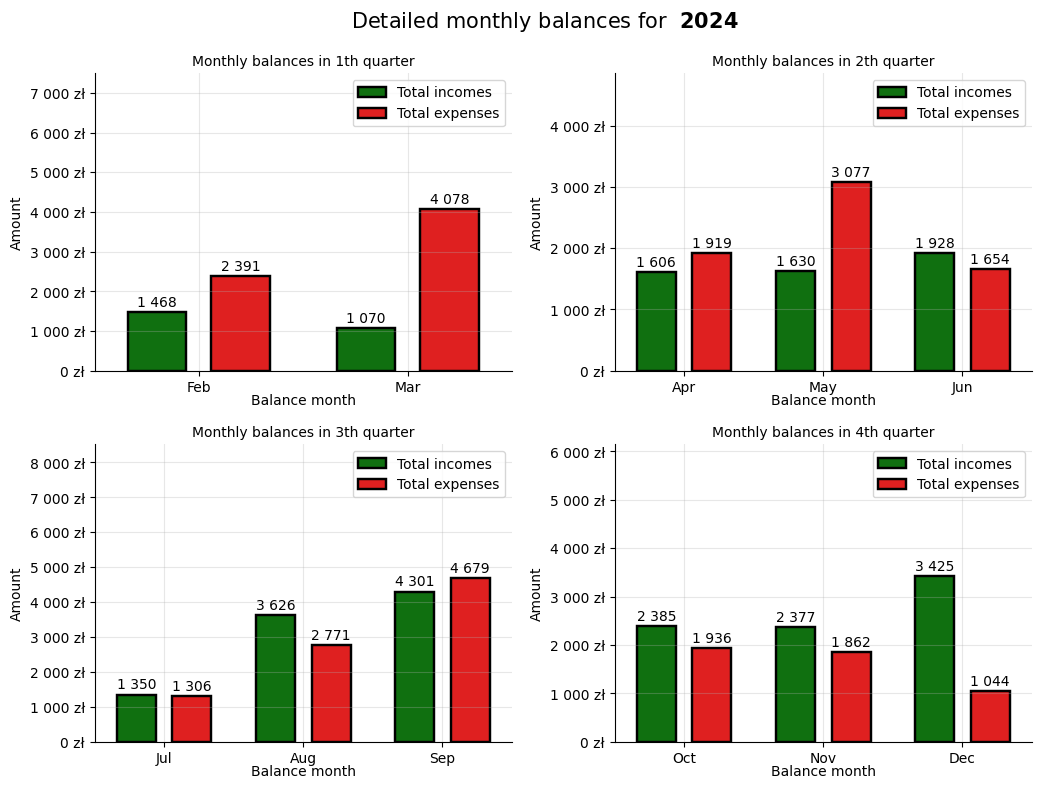

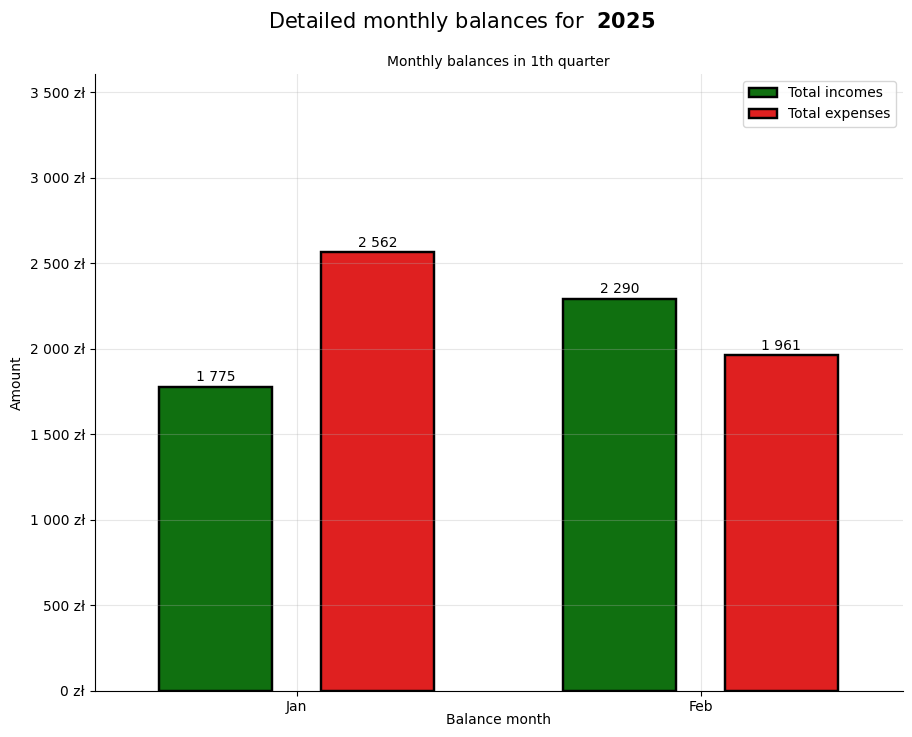

In [195]:
monthly_detailed_balances_path = path.Path().cwd() / "Detailed monthly balances"

def generate_month_detailed_balances(year: int) -> None:
    """Generate the month detailed balance sheet plot for a given year and save it.

    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None
    """
    # Filter the balance sheets and add a new column for "signed" amount.
    year_balance_sheets = balances_long.filter(
        pl.col("Year") == year,
        pl.col("Financial category").str.starts_with("Total")
    )

    # Create a FacetGrid for the quarters.
    facet_grid = sns.FacetGrid(
        data=year_balance_sheets, 
        col="Quarter", 
        col_wrap=min(2, year_balance_sheets["Quarter"].n_unique()), 
        sharex=False, 
        sharey=False
    )

    # Set title for each subplot.
    facet_grid.set_titles(template="Monthly balances in {col_name}th quarter")

    # Set the global title for the whole figure.
    facet_grid.fig.suptitle(
        fr"Detailed monthly balances for  $\bf{{{year}}}$",
        size=15
    )
    facet_grid.fig.subplots_adjust(top=0.9)  # Lift the title a little bit.

    for quarter_id, axes in facet_grid.axes_dict.items():
        # Find the rows from a given quarter.
        quarter_balance_sheets = year_balance_sheets.filter(pl.col("Quarter") == quarter_id)

        sns.barplot(
            data=quarter_balance_sheets, 
            x="Month", 
            y="Amount", 
            hue="Financial category",
            ax=axes,
            palette={"Total expenses": "red", "Total incomes": "green"},
            edgecolor="black",
            linewidth=1.75
        )

        # Find the minimum and maximum amount respectively.
        y_min, y_max = quarter_balance_sheets["Amount"].min(), quarter_balance_sheets["Amount"].max()

        axes.get_legend().set_title("")
        axes.set_xlabel("Balance month", labelpad=-1)
        axes.set_ylim(0, y_max * (1.1 + (y_max - y_min) / y_max))
        axes.yaxis.set_major_formatter(lambda x, v: f"{x:,.0f} zł".replace(",", " "))
        axes.grid(True, alpha=0.3)

        # Add bar labels.
        for container in axes.containers:
            axes.bar_label(container, fmt=lambda v: f"{v:,.0f}".replace(",", " "), padding=2)

        # Resize the width of the bars so that the bar labels wouldn't overlap.
        q = 0.7
        for patch in axes.patches:
            current_width = patch.get_width()
            patch.set_width(current_width * q)
            patch.set_x(patch.get_x() + current_width / 2 * (1 - q))

    # Get the figure.
    figure = axes.get_figure()

    # Change the shapes of the figure.
    figure.set_size_inches((8 * fig_aspect_ratio, 8))

    # Define the saving path.
    saving_path = main_path / f"{year}"

    if not saving_path.exists():
        saving_path.mkdir(parents=True)

    # Save the figure.
    figure.savefig(saving_path / "Detailed monthly balance")
# Generate the month detailed balance sheets for each year available in the dataset.
for year in balances_long["Year"].unique():
    generate_month_detailed_balances(year)

# 7. Visualizing the share of expense categories in monthly spendings.

In [196]:
def plot_the_share(df: pl.DataFrame, date_col: str, cat_col: str, cost_col: str, transaction_type: str) -> None:
    """The function visualizes the categories share in either expenses or incomes.

    Parameters:
    df : pl.DataFrame
        The dataframe storing the expenses or incomes.

    date_col : str
        The name of the date column.

    cat_col : str
        The name of the (expense/income) category column.

    cost_col : str
        The name of the cost column.

    transaction_type : str
        One of two types of transaction (expenses, incomes) we're visualizing.
    """
    cat_share = df.group_by(
        pl.col(date_col).dt.year().alias("Year"),
        pl.col(date_col).dt.strftime("%B").alias("Month"),
        pl.col(cat_col)
    ).agg(
        pl.sum(cost_col).alias("Total amount")
    )

    for year in cat_share["Year"].unique():
        for month in cat_share["Month"].unique():
            # Filter out the monthly expenses and add a normalized amount of the expenses.
            cat_share_filtered = cat_share.filter(
                (pl.col("Year") == year) & (pl.col("Month") == month)
            ).with_columns(
                (100 * pl.col("Total amount") / pl.sum("Total amount")).alias('Share')
            )

            if cat_share_filtered.shape[0]:
                # Create a condition to group the least-expensive categories.
                grouping_condition = pl.when(pl.col("Share") <= 1.5).then(
                    pl.lit("Other")
                ).otherwise(
                    pl.col(cat_col)
                ).alias(cat_col)

                # Group the least-expensive categories together.
                cat_share_filtered = cat_share_filtered.with_columns(
                    grouping_condition
                ).group_by(
                    pl.col(cat_col)
                ).agg(
                    pl.sum("Total amount"), pl.sum("Share")
                ).sort(
                    pl.col("Share"), descending=True
                )

                # Create a figure.
                fig, ax = plt.subplots(figsize=(6, 3))

                # Resize the figure.
                global height, width
                fig.set_size_inches(width, height)

                wedges, _ = plt.pie(
                    cat_share_filtered["Share"],
                    wedgeprops={"edgecolor": (0, 0, 0, 0.75), "linewidth": 1},
                )

                # Find the labels of each wedge.
                labels = cat_share_filtered[cat_col]

                # Define the formatter for percentage share.
                text_formatter = lambda t: f"{t:.2f}"

                for label, wedge, share in zip(labels, wedges, cat_share_filtered["Share"]):
                    # Find the starting and ending angles of the wedge.
                    theta1, theta2 = wedge.theta1, wedge.theta2

                    # Find the radius of the wedge.
                    radius = wedge.r

                    # Find the angle of the point the label will be located at.
                    angle = np.deg2rad((theta1 + 2 * theta2) / 3)

                    # Find the coordinates of the circle edge point.
                    x, y = np.cos(angle) * radius, np.sin(angle) * radius

                    # The point from the circumference.
                    xy = np.array([x, y])

                    # The tail point scaling factor.
                    q = 1.2 if x >= 0 else (1.2 if y >= 0 else 1.3)

                    # The arrow tail coordinates scaling factor, which should be in the [0;1] interval.
                    s = 0.9

                    # Find the tail and head of the arrow.
                    arrow_tail_xy, arrow_head_xy = s * xy, q * xy

                    # Create a good-looking label depending on the orientation of the wedge.
                    text = (label.replace(" ", "\n") + (", " if x >= 0 else "\n") + fr"$\bf{{{text_formatter(share)}}}\%$")

                    ax.annotate(
                        text=text, xy=arrow_tail_xy, xytext=arrow_head_xy,
                        arrowprops={"arrowstyle": "<-", "connectionstyle": "Angle3", "color": "black", "linewidth": 1, "linestyle": "dashed"},
                        fontsize=9
                    )

                ax.set_title(
                    f"Monthly categories share in {transaction_type.lower()} in " + rf"$\bf{{{month}, {year}}}$",
                    loc="right", fontsize=12
                )

                # Save the figure.
                saving_path = main_path / f"{year}" / f"{month_order[month]} {month}"
                saving_path.mkdir(parents=True, exist_ok=True)

                fig.savefig(fname=saving_path / f"Categories share in {transaction_type.lower()}")
                plt.close()

# Plot the share for expenses and incomes.
plot_the_share(expenses_df, "Expense date", "Expense category", "Expense cost", "Expenses")
plot_the_share(income_df, "Income date", "Income category", "Income amount", "Incomes")

# 8. Average monthly costs. ( to remove, it's gonna be replace by density plots!)

In [197]:
# # Group the expenses by date and expense category.
# grouped_expenses = (
#     expenses_df.group_by(
#         pl.col("Expense date").alias("Date"),
#         pl.col("Expense category").alias("Category"),
#         maintain_order = True
#     ).agg(
#         pl.sum("Expense cost").alias("Cost")
#     )
# )

# # Define grouping variables for year, month, and category.
# grouping_vars = [
#     pl.col("Date").dt.year().alias("Year"),
#     pl.col("Date").dt.strftime("%B").alias("Month"),
#     pl.col("Category")
# ]

# # Group the expenses by year, month, and category, then sum the costs.
# df = grouped_expenses.group_by(grouping_vars).agg(pl.sum("Cost"))

# # Group again by month and category, then compute the average cost and cast the average cost to integer.
# df = df.group_by(
#     pl.col("Month"),
#     pl.col("Category")
# ).agg(
#     pl.mean("Cost").round(2).alias("Avg cost")
# )

# # Sort the DataFrame.
# df = df.sort(
#     pl.col("Month").replace_strict(month_order),
#     pl.col("Category")
# )

# # Pivot the DataFrame to get the monthly average expenses.
# avg_monthly_cost = df.pivot(
#     on="Month",
#     index="Category",
#     values="Avg cost"
# ).fill_null(0)




# # Group the expenses by year and category, then sum the costs.
# annual_grouped_expenses = (
#     grouped_expenses.group_by(
#         pl.col("Date").dt.year().alias("Rok"),
#         pl.col("Category")
#     ).agg(
#         pl.sum("Cost").round(2)
#     )
# )

# # Group again by category and compute the average annual cost.
# avg_annual_cost = (
#     annual_grouped_expenses.group_by(
#         pl.col("Category")
#     ).agg(
#         pl.mean("Cost").alias("Average annual cost").round(2)
#     )
# )



# avg_monthly_cost = ( 
#                 avg_monthly_cost.join(avg_annual_cost, on="Category"
#                 ).sort(pl.col("Average annual cost"), 
#                 descending = True
#                 ) 
# )



# saving_path = main_path/"Average monthly expenses"
# saving_path.mkdir(parents = True, exist_ok = True)


# # Save the DataFrame to a CSV file.
# avg_monthly_cost.write_csv(saving_path/"Average monthly expenses.csv",
#                            include_header = True,
#                            separator=",",
# )

# 8. Total monthly costs.

In [198]:

for year in expenses_df["Expense date"].dt.year().unique():
    # Filter the expenses by year 
    # and group them by month and categories 
    # and then sum the total cost for each group.
    total_monthly_expenses = (
        expenses_df.filter(pl.col("Expense date").dt.year() == year)
        .group_by(
            pl.col("Expense date").dt.strftime("%B").alias("Month"),
            pl.col("Expense category").alias("Category")
        ).agg(
            pl.sum("Expense cost").round(2).alias("Total cost")
        ).sort(
            pl.col("Month").replace_strict(month_order)
        )
    )

    # Let's transforme the dataframe to wide form.
    total_monthly_expenses = total_monthly_expenses.pivot(
        index="Category",
        on="Month",
        values="Total cost"
    ).fill_null(0)

    total_monthly_expenses = (
        total_monthly_expenses.with_columns(
            total_monthly_expenses.select(sc.numeric()).
            sum_horizontal()
            .alias("Total cost").round(2)
        ).sort(
            pl.col("Total cost"),
            descending = True
        )
    )

    saving_path = main_path/rf"{year}"/f"Total monthly"

    saving_path.mkdir(parents = True, exist_ok = True)

    total_monthly_expenses.write_csv(saving_path/r"Total monthly expenses.csv",
                                     separator=",")
    
   



# 9. Total monthly incomes.

In [199]:

for year in income_df["Income date"].dt.year().unique():
    # Filter the incomes by year 
    # and group them by month and categories 
    # and then sum the total cost for each group.
    total_monthly_income = (
        income_df.filter(pl.col("Income date").dt.year() == year)
        .group_by(
            pl.col("Income date").dt.strftime("%B").alias("Month"),
            pl.col("Income category").alias("Category")
        ).agg(
            pl.sum("Income amount").round(2).alias("Total income")
        ).sort(
            pl.col("Month").replace_strict(month_order)
        )
    )


    # Let's transforme the dataframe to wide form.
    total_monthly_income = total_monthly_income.pivot(
        index="Category",
        on="Month",
        values="Total income"
    ).fill_null(0)

    total_monthly_income = (
        total_monthly_income.with_columns(
            total_monthly_income.select(sc.numeric()).
            sum_horizontal()
            .alias("Total income").round(2)
        ).sort(
            pl.col("Total income"),
            descending = True
        )
    )



    saving_path = main_path/rf"{year}"/f"Total monthly"

    saving_path.mkdir(parents = True, exist_ok = True)


    total_monthly_income.write_csv(saving_path/r"Total monthly income.csv",
                                     separator=",")


# 10. Expense categories monthly frequencies.


In [200]:
for year in expenses_df["Expense date"].dt.year().unique():
    # Filter the expenses for the specified year and get unique entries.
    df = expenses_df.filter(
        pl.col("Expense date").dt.year() == year
    ).unique(
        ["Expense date", "Where bought?", "Expense category"],
        maintain_order=True
    )

    # Group by month and expense category, then count the occurrences.
    df = df.group_by(
        pl.col("Expense date").dt.strftime("%B").alias("Month"),
        pl.col("Expense category"),
        maintain_order=True
    ).agg(
        pl.count("Expense category").alias("Count").round(2)
    )

    # Calculate the frequency and drop the count column.
    df = (
        df.with_columns(
            (100 * pl.col("Count") / pl.sum("Count").over(pl.col("Month"))).round(2).alias("Frequency")
        )
        .drop("Count")
        .sort(
            pl.col("Month").replace_strict(month_order)
        )
    )


    # Convert the dataframe to wide form.
    df = df.pivot(on = "Month", 
                index = "Expense category", 
                values = "Frequency").fill_null(0)

    saving_path = main_path/f"{year}"


    df.write_csv(saving_path/"Expense categories frequency.csv",
                include_header = True)

# 11. The daily cost distributions.

In [202]:
# Define a cost formatter function
cost_formatter: callable = lambda v: f"{v:,.0f}".replace(",", "")  # Format numbers with no commas

# Define a function to find the closest point in an array
find_closest_point: callable = lambda x0, x: np.argmin(abs(x0 - x))


expenses_df_grouped: pl.DataFrame = expenses_df.group_by(pl.col("Expense date"), pl.col("Expense category")).agg(
                pl.sum("Expense cost").alias("Cost")
            )

for year in expenses_df["Expense date"].dt.year().unique():
    for month in expenses_df["Expense date"].dt.month().unique():
        saving_path = main_path/f"{year}"/f"{month} {int2month[month]}"/f"Expense distributions"
  

        for category in expenses_df["Expense category"].unique():
            # Filter the expenses data by year, month, and category
            cat_df: pl.DataFrame = expenses_df_grouped.filter(
                pl.col("Expense date").dt.year() == year,
                pl.col("Expense date").dt.month() == month,
                pl.col("Expense category") == category
            )

            if cat_df.shape[0]:
                # Check if the dataframe has at least two records
                has_min_two: bool = cat_df.shape[0] > 1


                # Compute the mean and standard deviation of the costs
                mean: float = cat_df["Cost"].mean()
                sd: float = 0 if not has_min_two else cat_df["Cost"].std()


                # Create a figure and axes for plotting
                fig = plt.figure()
                axes = fig.add_subplot()


                # If the standard deviation is greater than zero, plot the estimated density
                if sd > 0:
                    sns.kdeplot(cat_df, x="Cost", linewidth=2, ax=axes)

                    # Get the data points from the plot
                    X, Y = axes.get_lines()[0].get_data()


                    # Generate points within the interval [mean - sd, mean + sd]
                    x: np.ndarray = np.arange(mean - sd, mean + sd, 0.01)


                    # Vectorize the 'find_closest_point' function
                    find_closest_point_vec: callable = np.vectorize(find_closest_point, excluded=["x"])


                    # Find the indices of the closest points
                    min_idx: np.ndarray = find_closest_point_vec(x0=x, x=X)


                    # Compute the y-coordinates of the closest points
                    y: np.ndarray = Y[min_idx]

                    # Estimate the probability the cost will lie between (mean-sd, mean+sd)
                    prob: float = np.sum((x[1:]-x[:-1])*y[1:])


                    # Fill the area within one standard deviation from the mean
                    area = axes.fill_between(x=x, y1=0, y2=y, color="red", alpha=0.2)


                    # Draw a vertical line at the mean
                    mean_y: float  = y[find_closest_point(mean, X)]

                    line = axes.vlines(mean, 0, 0.8*mean_y, color="red", linestyle="dotted", linewidth=3)

                    axes.annotate(f"{100*prob:.2f}%", xy=(mean-sd,mean_y*0.8))


                    # Add a legend to the plot
                    axes.legend(handles=[area, line], labels=["One-sd from mean interval", "Expectation"],
                                loc = "upper left",
                                framealpha = 0.4)

                

                # If the standard deviation is zero, plot a bar chart
                else:
                    atom = cat_df["Cost"][0]

                    sns.barplot(x=[atom], y=[1], width=0.2, edgecolor="black", linewidth=2)

                    # Set the x-axis limits
                    axes.set_xlim(0, 1)
                    bar = axes.containers[0][0]

                    # Find the anchor of the bar
                    x, y = 0.5 - bar.get_width() / 2, 0
                    bar.set_xy(xy=(x, y))

                    # Set the x-axis ticks and labels
                    axes.set_xticks([0, x + bar.get_width() / 2], labels=["0", cost_formatter(atom)])


                # Add grid lines and hide the top and right spines
                axes.grid(True, alpha=0.4)
                axes.spines[["top", "right"]].set_visible(False)
                axes.set_title("The cost distribution for \n"+rf"$\bf{{{category}}}$")

                if not saving_path.exists():
                    saving_path.mkdir(parents = True)
                fig.savefig(saving_path/f"{category} costs distribution.png")
                plt.close()